Please select the tmp_sp4_publication_env to run this script

In [78]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from shapely.geometry import Polygon
from skimage.io import imread as skimread
from shapely import wkt
from companion_functions import (
    plot_polygons
)
from shapely.ops import unary_union

import scanpy as sc


In [79]:
polygons_enact = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--18-25-15/ENACTApp_VisiumHD_ResusM_Kidney/cells_df.csv'

polygons_sp4 = '/srv/gstore/projects/p37785/RhesusM/segmented_outputs/cell_segmentations.geojson'

wsi_image_path = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--18-25-15/ENACTApp_VisiumHD_ResusM_Kidney/tmap/wsi.tif'

In [80]:

# Load the Visium full resolution image
wsi_image = skimread(wsi_image_path)


In [81]:
# Filter polygons to those that overlap the zoomed region
def polygon_in_crop(polygon, x_min, x_max, y_min, y_max):
    # polygon: (N,) array of interleaved x and y coordinates
    xs = polygon[::2]  # x coordinates are at even indices
    ys = polygon[1::2] # y coordinates are at odd indices
    return (
        (xs >= x_min).any() and (xs < x_max).any() and
        (ys >= y_min).any() and (ys < y_max).any()
    )

# Shift polygons so they match the crop region
def shift_polygon(polygon, x_min, y_min):
    shifted_polygon = polygon.copy()
    shifted_polygon[::2] -= x_min  # Subtract x_min from x coordinates
    shifted_polygon[1::2] -= y_min # Subtract y_min from y coordinates
    return shifted_polygon

In [82]:
import json

# Load the SpaceRanger v4 segmentation from geojson
with open(polygons_sp4, "r") as f:
    sp4_geojson = json.load(f)

# Extract polygons from geojson
sp4_polygons = []
for feature in sp4_geojson["features"]:
    coords = feature["geometry"]["coordinates"][0]  # Outer ring
    coords = [[x - 260, y - 200] for x, y in coords]
    sp4_polygons.append(np.array(coords).flatten())

# Compute centers for SpaceRanger v4 polygons
sp4_centers = np.array([
    np.mean(poly.reshape(-1, 2), axis=0) for poly in sp4_polygons
])

# ENACT loading remains unchanged
enact_cell_polygons = pd.read_csv(polygons_enact)
enact_cell_polygons = enact_cell_polygons.dropna(subset=['geometry'])
enact_cell_polygons["parsed_geometry"] = enact_cell_polygons["geometry"].apply(wkt.loads)
enact_cell_polygons["parsed_coordinates"] = enact_cell_polygons["parsed_geometry"].apply(
    lambda geom: np.array(geom.exterior.coords).flatten()
)
enact_polygons = enact_cell_polygons["parsed_coordinates"].to_numpy()
enact_centers = np.array([
    np.mean(poly.reshape(-1, 2), axis=0) for poly in enact_polygons
])


In [83]:
crop_size = 1000
x_min, y_min = 4500, 4500  # Starting coordinates for the crop
x_max,y_max = x_min + crop_size, y_min + crop_size  # Ending coordinates for the crop


In [84]:

sp4_crop_polygons_demean = [
    shift_polygon(poly, *center).reshape(-1, 2)
    for poly, center in zip(sp4_polygons, sp4_centers)
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]
enact_crop_polygons_demean = [
    shift_polygon(poly, *center).reshape(-1, 2)
    for poly, center in zip(enact_polygons, enact_centers)
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]

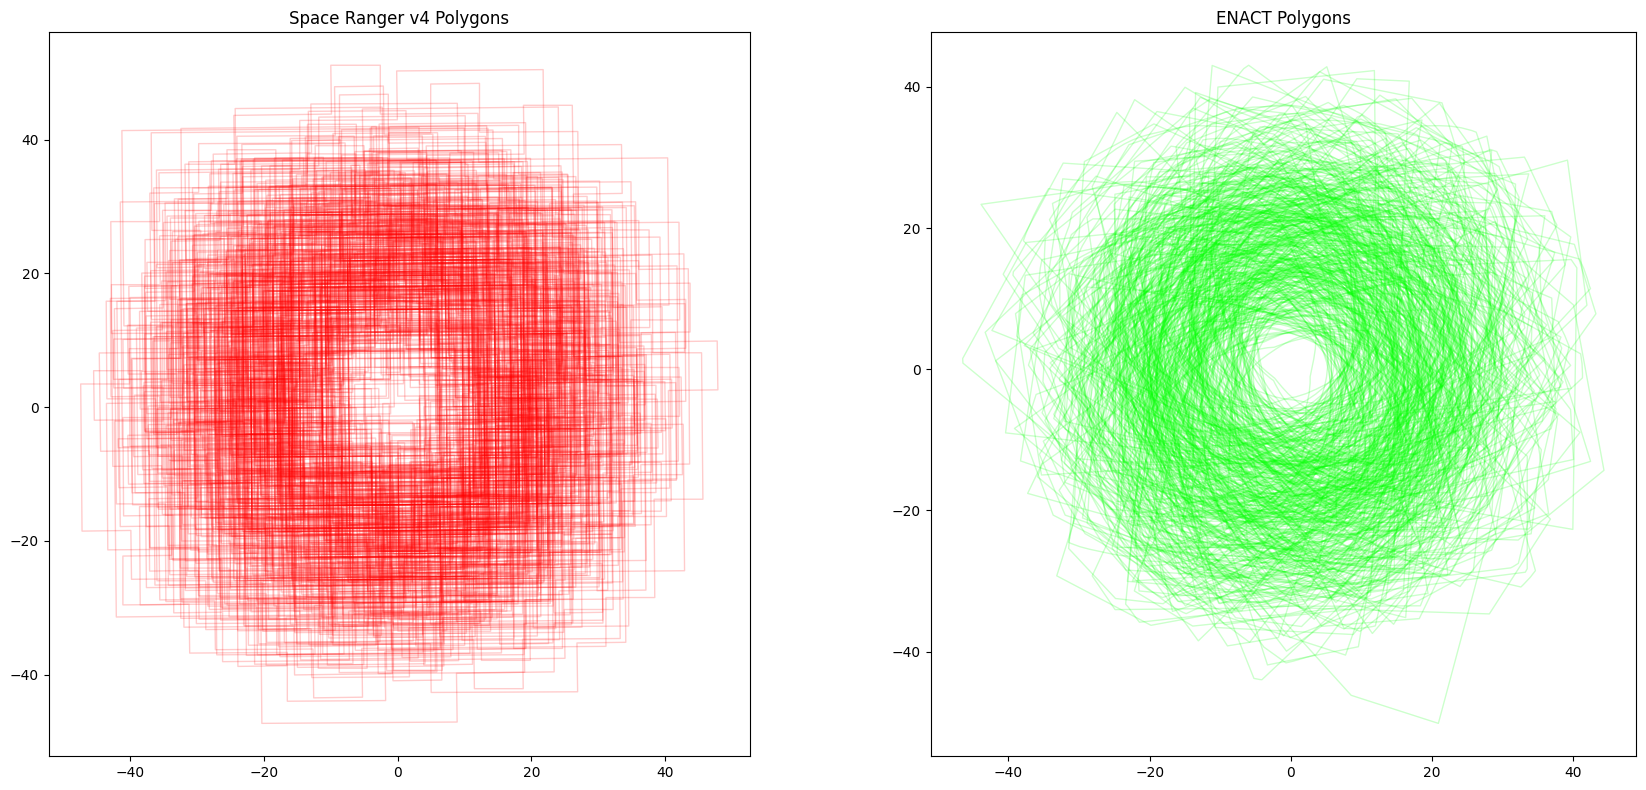

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# sp4 polygons
plot_polygons(
    sp4_crop_polygons_demean,
    ax=axs[0],
    facecolor=(0, 0, 0, 0),  # transparent face
    edgecolor=(1, 0, 0, 0.2),  # red with alpha=0.2 for transparency
    linewidth=1,
    zorder=2,
)
axs[0].set_title("Space Ranger v4 Polygons")
axs[0].set_aspect("equal")

# ENACT polygons
plot_polygons(
    enact_crop_polygons_demean,
    ax=axs[1],
    facecolor=(0, 0, 0, 0),
    edgecolor=(0, 1, 0, 0.2),  # green with alpha=0.2 for transparency
    linewidth=1,
)
axs[1].set_title("ENACT Polygons")
axs[1].set_aspect("equal")

plt.tight_layout()
plt.show()

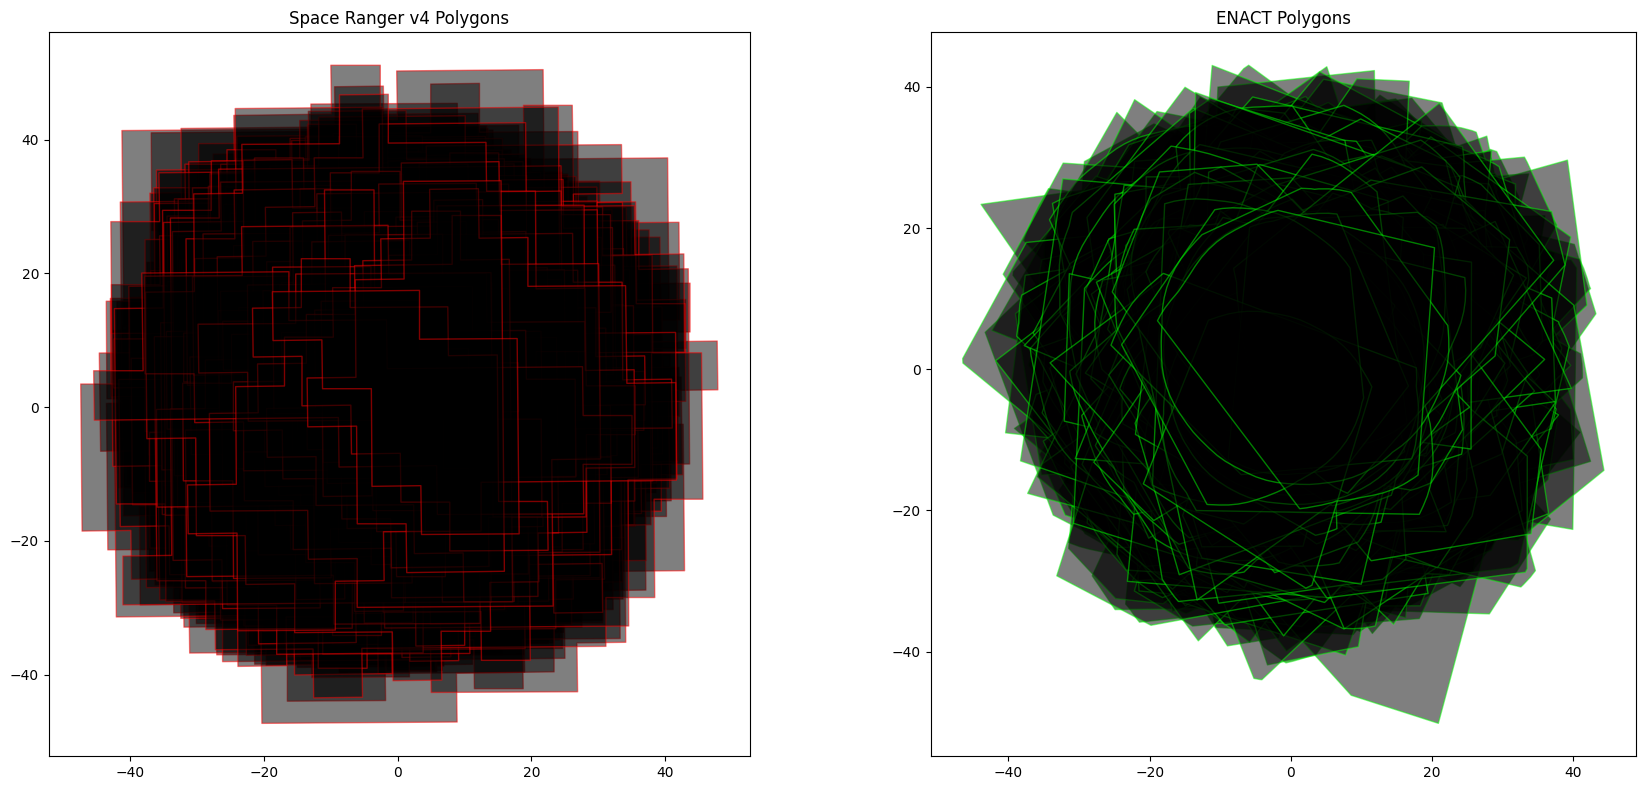

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# sp4 polygons
plot_polygons(
    sp4_crop_polygons_demean,
    ax=axs[0],
    facecolor=(0, 0, 0, 0.5),  
    edgecolor=(1, 0, 0, 0.5),  
    linewidth=1,
)
axs[0].set_title("Space Ranger v4 Polygons")
axs[0].set_aspect("equal")

# ENACT polygons
plot_polygons(
    enact_crop_polygons_demean,
    ax=axs[1],
    facecolor=(0, 0, 0, 0.5),
    edgecolor=(0, 1, 0, 0.5), 
    linewidth=1, 
)
axs[1].set_title("ENACT Polygons")
axs[1].set_aspect("equal")

plt.tight_layout()
plt.show()

In [87]:

sp4_crop_polygons = [
    shift_polygon(poly, x_min, y_min).reshape(-1, 2) for poly in sp4_polygons
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]

enact_crop_polygons = [
    shift_polygon(poly, x_min, y_min).reshape(-1, 2) for poly in enact_polygons
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]


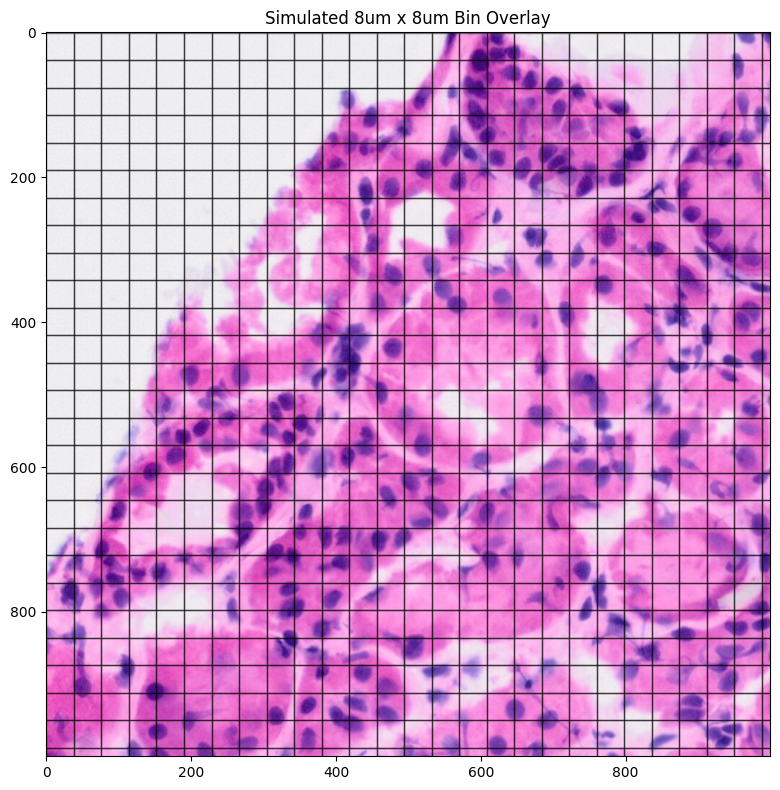

In [88]:

# Calculate the size of 8um in pixels
um_size = 8
pixel_size_um = 4.7  # pixels per 1um
square_size_px = int(round(um_size * pixel_size_um))

fig, ax = plt.subplots(figsize=(8, 8))
# Show the crop region of the WSI image
ax.imshow(wsi_image[y_min:y_max, x_min:x_max])

# Overlay 8um x 8um squares (space filling)
for i in range(0, crop_size, square_size_px):
    for j in range(0, crop_size, square_size_px):
        rect = plt.Rectangle(
            (i, j),
            square_size_px,
            square_size_px,
            linewidth=1.0,
            edgecolor='Black',
            facecolor='none',
            alpha=0.5
        )
        ax.add_patch(rect)

ax.set_title("Simulated 8um x 8um Bin Overlay")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

In [89]:
sp4_polygons = [poly.reshape(-1, 2) for poly in sp4_polygons]
enact_polygons = [poly.reshape(-1, 2) for poly in enact_polygons]

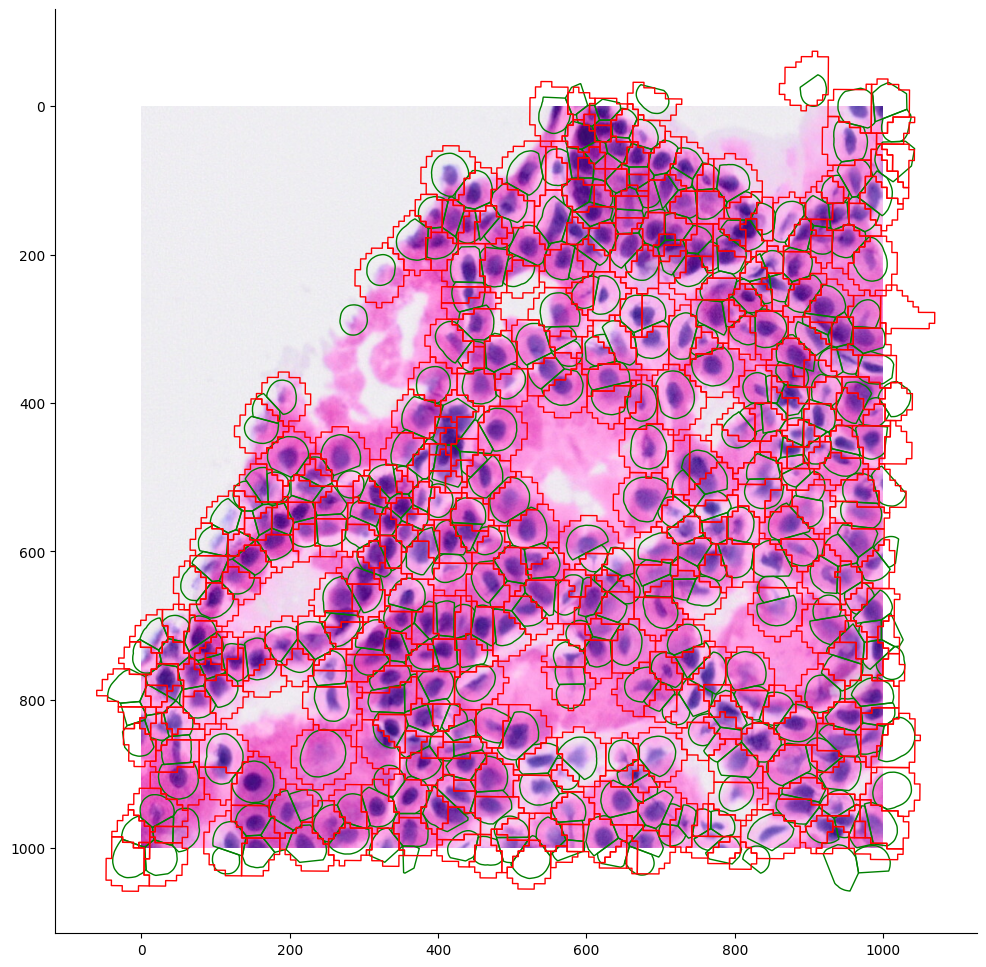

In [110]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

# Show zoomed region of the full resolution image
ax.imshow(
    wsi_image[y_min:y_max, x_min:x_max]
)
plot_polygons(
    enact_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="green",
    linewidth=1,
)

plot_polygons(
    sp4_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="red",
    linewidth=1,
)

# Plot style adjustments
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")

! Note that having a too large expansion parameter (as may be the case here for sp4) can lead to having more diverse cell areas (tails, see below) at the cost of oversegmentation. 

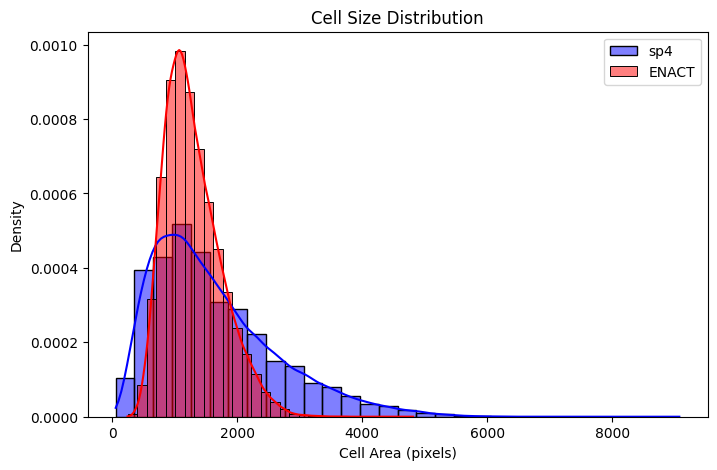

In [111]:
import seaborn as sns

# Calculate areas
sp4_areas = [Polygon(poly).area for poly in sp4_polygons]
enact_areas = [Polygon(poly).area for poly in enact_polygons]

plt.figure(figsize=(8, 5))
sns.histplot(sp4_areas, color="blue", label="sp4", kde=True, stat="density", bins=30, alpha=0.5)
sns.histplot(enact_areas, color="red", label="ENACT", kde=True, stat="density", bins=30, alpha=0.5)
plt.xlabel("Cell Area (pixels)")
plt.ylabel("Density")
plt.title("Cell Size Distribution")
plt.legend()
plt.show()

In [92]:
from shapely.geometry import Polygon

# Compute areas in pixels for ENACT and sp4
enact_areas = [Polygon(poly).area for poly in enact_polygons]
sp4_areas = [Polygon(poly).area for poly in sp4_polygons]

# Mean and median in pixels
enact_mean_area_px = np.mean(enact_areas)
enact_median_area_px = np.median(enact_areas)
sp4_mean_area_px = np.mean(sp4_areas)
sp4_median_area_px = np.median(sp4_areas)

print(f"ENACT mean area: {enact_mean_area_px:.2f} px, median area: {enact_median_area_px:.2f} px")
print(f"sp4 mean area: {sp4_mean_area_px:.2f} px, median area: {sp4_median_area_px:.2f} px")

# Conversion to um^2 (replace PIXEL_SIZE_UM with your value)
PIXEL_SIZE_UM = 4.7  # placeholder, update with your pixel size in microns
enact_mean_area_um2 = enact_mean_area_px / (PIXEL_SIZE_UM ** 2)
enact_median_area_um2 = enact_median_area_px / (PIXEL_SIZE_UM ** 2)
sp4_mean_area_um2 = sp4_mean_area_px / (PIXEL_SIZE_UM ** 2)
sp4_median_area_um2 = sp4_median_area_px / (PIXEL_SIZE_UM ** 2)

print(f"ENACT mean area: {enact_mean_area_um2:.2f} um^2, median area: {enact_median_area_um2:.2f} um^2")
print(f"sp4 mean area: {sp4_mean_area_um2:.2f} um^2, median area: {sp4_median_area_um2:.2f} um^2")

ENACT mean area: 1289.71 px, median area: 1212.93 px
sp4 mean area: 1631.21 px, median area: 1389.64 px
ENACT mean area: 58.38 um^2, median area: 54.91 um^2
sp4 mean area: 73.84 um^2, median area: 62.91 um^2


In [93]:
def compute_iou(poly1, poly2):
    """Compute IoU between two shapely polygons."""
    inter = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return inter / union if union > 0 else 0

def compute_dice(poly1, poly2):
    """Compute Dice coefficient between two shapely polygons."""
    inter = poly1.intersection(poly2).area
    return 2 * inter / (poly1.area + poly2.area) if (poly1.area + poly2.area) > 0 else 0


In [94]:
# Combine all polygons into one for each segmentation
sp4_crop_union = unary_union([Polygon(poly) for poly in sp4_crop_polygons])
enact_crop_union = unary_union([Polygon(poly) for poly in enact_crop_polygons])

# Compute IoU and Dice for the combined segmentation
combined_iou = compute_iou(sp4_crop_union, enact_crop_union)
print(f"Combined IoU (crop): {combined_iou:.3f}")

combined_dice = compute_dice(sp4_crop_union, enact_crop_union)
print(f"Combined Dice (crop): {combined_dice:.3f}")

Combined IoU (crop): 0.738
Combined Dice (crop): 0.849


In [95]:
havetime = False

In [96]:
if havetime:
    # Combine all polygons into one for each segmentation
    sp4_union = unary_union([Polygon(poly) for poly in sp4_polygons])
    enact_union = unary_union([Polygon(poly) for poly in enact_polygons])

    # Compute IoU and Dice for the combined segmentation
    combined_iou = compute_iou(sp4_union, enact_union)
    print(f"Combined IoU (all cells): {combined_iou:.3f}")

    combined_dice = compute_dice(sp4_union, enact_union)
    print(f"Combined Dice (all cells): {combined_dice:.3f}")

In [97]:
# Define the crop as a polygon
crop_poly = Polygon([
    (0, 0),
    (crop_size, 0),
    (crop_size, crop_size),
    (0, crop_size)
])

# Fraction of crop covered by each segmentation
sp4_frac = sp4_crop_union.area / crop_poly.area
enact_frac = enact_crop_union.area / crop_poly.area

print(f"sp4: {sp4_frac:.3%} of crop area covered")
print(f"ENACT: {enact_frac:.3%} of crop area covered")

sp4: 78.872% of crop area covered
ENACT: 59.509% of crop area covered
